In [1]:
import numpy as np
import tensorflow as tf

In [2]:
class NFMComponent(tf.keras.layers.Layer):
    """
    没啥好说的，注释不补了
    """
    def __init__(self,feat_dim,field_num,emb_dim,dense_units_list,*args,**kwargs):
        super(NFMComponent,self).__init__(*args,**kwargs)
        self.feat_dim=feat_dim
        self.field_num=field_num
        self.emb_dim=emb_dim
        self.emb_layer=tf.keras.layers.Embedding(input_dim=feat_dim,output_dim=emb_dim)

        self.dense_layers=list()
        for units in dense_units_list:
            self.dense_layers.append(tf.keras.layers.Dense(units=units,activation=tf.nn.relu))
        self.scoring_layer=tf.keras.layers.Dense(units=1,activation=None)

    def call(self, inputs, **kwargs):

        """

        :param inputs: a batch of data shape: [batch_size, 2, field_num]，在deep fm数据结构的基础上做了点改进，将feat_index和feat_value拼了起来，为的是最后容易画图
            分为两部分，你可以把他看做一个手动构造的稀疏矩阵，每个样本的输入形状都是[2, field_num]
            例如，如果inputs的数据为[[[1,5,9],[1,1,2.3]], [[2,7,8],[1,1,0.98]]]；
            假设第一个样本的特征向量是x，那么x[1]=1, x[5]=1, x[9]=2.3，其余位置取值均为0
            这样构造的好处和deep fm中描述的相同。
        :param kwargs:
        :return:
        """

        feat_indices_batch=inputs[:,0,:] # [batch_size, field_num]
        feat_value_batch=inputs[:,1,:] # [batch_size, field_num]
        assert inputs.shape[1:]==[2, self.field_num]

        emb_vectors=self.emb_layer(feat_indices_batch) # [batch_size, field_num, emb_dim]
        feat_value_batch = tf.expand_dims(feat_value_batch,axis=-1) # [batch_size, field_num, 1]

        # broadcast性质 feat_value_batch会被看做[batch_size, field_num, emb_dim]
        emb_vectors = tf.multiply(emb_vectors,feat_value_batch) # [batch_size, field_num, emb_dim]

        # bi interaction pooling
        sum_square=tf.square(tf.reduce_sum(emb_vectors,axis=1)) # [batch_size, emb_dim]
        square_sum=tf.reduce_sum(tf.square(emb_vectors),axis=1) # [batch_size, emb_dim]
        outputs=1/2*tf.subtract(sum_square,square_sum)

        # dense_layers
        for dense_layer in self.dense_layers:
            outputs=dense_layer(outputs)

        outputs=self.scoring_layer(outputs)
        return outputs

feat_indices_arr=[np.random.choice(range(10),size=[1,3],replace=False) for _ in range(9)]
feat_indices_arr=np.concatenate(feat_indices_arr,axis=0).astype(np.float32)
print("feat_indices_arr")
print(feat_indices_arr.shape) #[10,3]

feat_vals_arr=np.concatenate((np.ones(shape=[9,2]),
                              np.random.random(size=[9,1])),axis=1).astype(np.float32)
print("\nfeat_vals_arr")
print(feat_vals_arr.shape) # [10,3]

input_arr=np.stack((feat_indices_arr,feat_vals_arr),axis=1)
input_ds=tf.data.Dataset.from_tensor_slices(input_arr)
batched_ds=input_ds.batch(5)
iterator=iter(batched_ds)
input_batch=next(iterator)
print("\ninput_batch")
print(input_batch.shape)


print("\nemb vectors")
nfm_layer=NFMComponent(feat_dim=10,field_num=3,emb_dim=4,dense_units_list=[8,4])
nfm_outputs=nfm_layer(input_batch)
print(nfm_outputs)

feat_indices_arr
(9, 3)

feat_vals_arr
(9, 3)

input_batch
(5, 2, 3)

emb vectors
tf.Tensor(
[[0.00127318]
 [0.00044792]
 [0.00040752]
 [0.00022372]
 [0.00094298]], shape=(5, 1), dtype=float32)


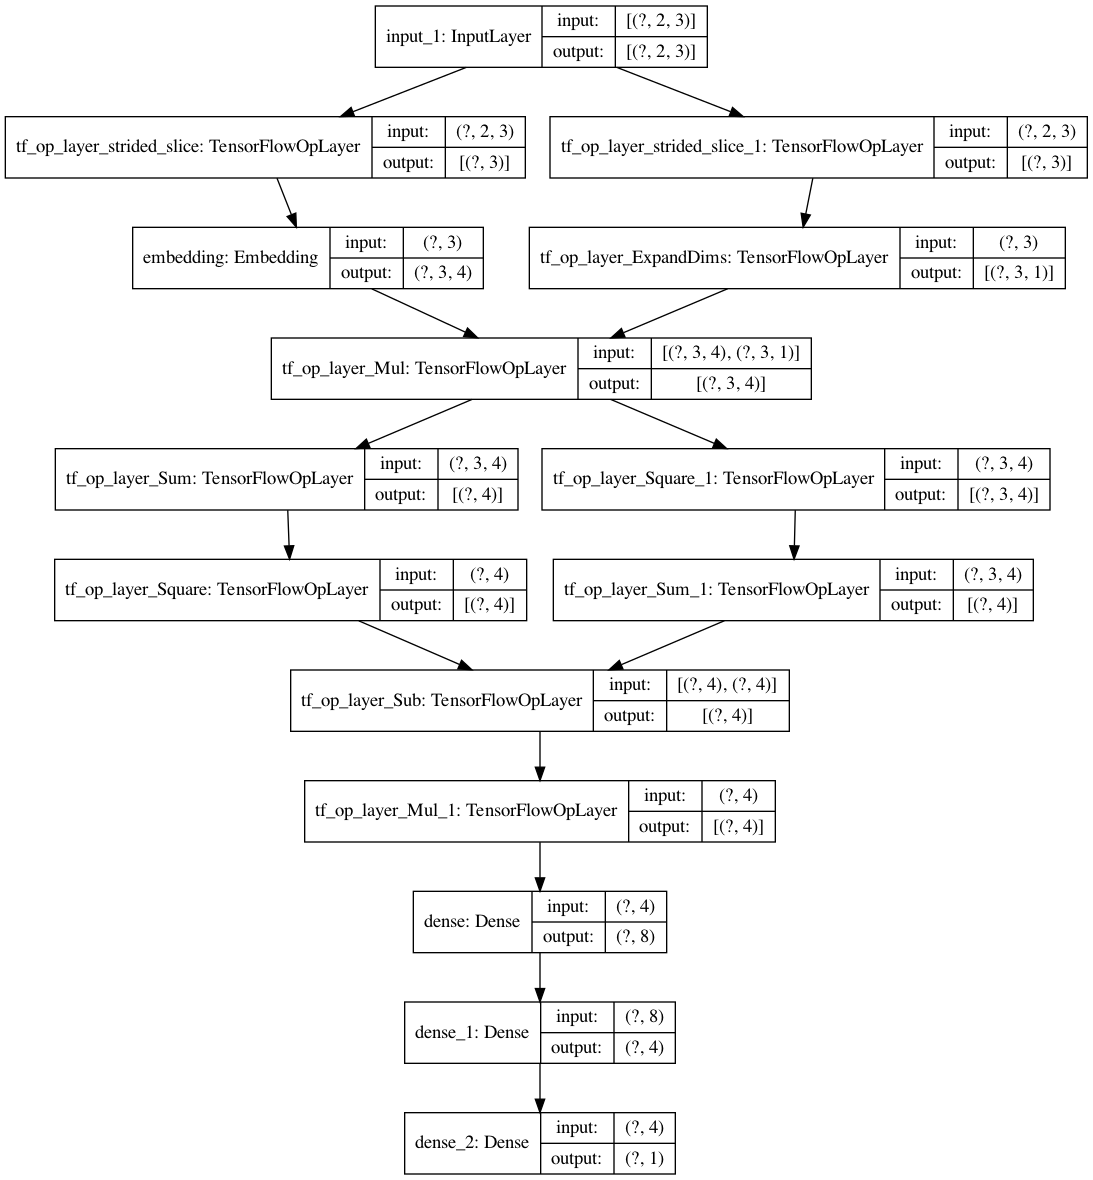

In [3]:
inputs_node=tf.keras.Input(shape=[2,3],dtype=tf.float32)
outputs_node=nfm_layer.call(inputs_node)
nfm_layer_for_plot=tf.keras.Model(inputs=inputs_node,outputs=outputs_node)
tf.keras.utils.plot_model(nfm_layer_for_plot,show_shapes=True,show_layer_names=True)

In [10]:
class NFMModel(tf.keras.Model):
    def __init__(self,feat_dim,field_num,emb_dim,dense_units_list,*args,**kwargs):
        super(NFMModel,self).__init__(*args,**kwargs)
        self.nfm_component=NFMComponent(feat_dim=feat_dim,field_num=field_num,emb_dim=emb_dim,dense_units_list=dense_units_list)
        self.w=tf.Variable(tf.random.truncated_normal(shape=[self.nfm_component.feat_dim,]))
        self.b=tf.Variable(tf.random.truncated_normal(shape=[]))

    def call(self, inputs, training=None, mask=None):
        feat_indices_batch=inputs[:,0,:] # [batch_size, field_num]
        feat_value_batch=inputs[:,1,:] # [batch_size, field_num]
        first_order_term_weights=tf.nn.embedding_lookup(params=self.w,ids=tf.cast(feat_indices_batch,tf.int32)) # [batch_size, field_num]

        first_order_term=tf.multiply(first_order_term_weights,feat_value_batch)+self.b # [batch_size, field_num]
        first_order_term = tf.reduce_sum(first_order_term,axis=1,keepdims=True) # [batch_size, 1]
        print(first_order_term)

        nfm_outputs=self.nfm_component(inputs) # [batch_size, 1]
        print(nfm_outputs)
        outputs=nfm_outputs+first_order_term

        return outputs


feat_indices_arr=[np.random.choice(range(10),size=[1,3],replace=False) for _ in range(9)]
feat_indices_arr=np.concatenate(feat_indices_arr,axis=0).astype(np.float32)
print("feat_indices_arr")
print(feat_indices_arr.shape) #[10,3]

feat_vals_arr=np.concatenate((np.ones(shape=[9,2]),
                              np.random.random(size=[9,1])),axis=1).astype(np.float32)
print("\nfeat_vals_arr")
print(feat_vals_arr.shape) # [10,3]

input_arr=np.stack((feat_indices_arr,feat_vals_arr),axis=1)
input_ds=tf.data.Dataset.from_tensor_slices(input_arr)
batched_ds=input_ds.batch(5)
iterator=iter(batched_ds)
input_batch=next(iterator)
print("\ninput_batch")
print(input_batch.shape)


print("\nnfm_model outputs")
nfm_model=NFMModel(feat_dim=10,field_num=3,emb_dim=4,dense_units_list=[8,4])
nfm_outputs=nfm_model(input_batch)
print(nfm_outputs)



feat_indices_arr
(9, 3)

feat_vals_arr
(9, 3)

input_batch
(5, 2, 3)

nfm_model outputs
tf.Tensor(
[[2.9444218]
 [3.054676 ]
 [2.7317686]
 [3.777637 ]
 [3.265613 ]], shape=(5, 1), dtype=float32)
tf.Tensor(
[[-0.00214292]
 [-0.00106353]
 [-0.00157683]
 [-0.00254426]
 [-0.00102274]], shape=(5, 1), dtype=float32)
tf.Tensor(
[[2.9422789]
 [3.0536125]
 [2.7301917]
 [3.7750928]
 [3.2645903]], shape=(5, 1), dtype=float32)
